# Setup

### Load image data

In [1]:
from keras.datasets import cifar10
(trainX, trainy), (testX, testy) = cifar10.load_data()

# Scale down pixcel value range to from [0,255] to [0,1]
trainX = trainX.astype("float32")
testX = testX.astype("float32")
trainX /= 255
testX  /= 255

# Change format of y to 1-hot vector
from keras.utils import np_utils
trainY = np_utils.to_categorical(trainy, 10)
testY = np_utils.to_categorical(testy, 10)

Using Theano backend.


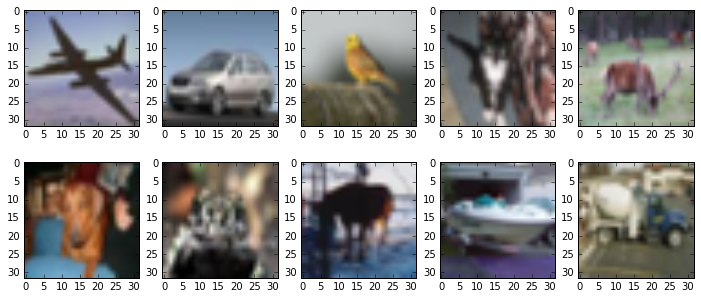

In [76]:
import random

def fetch_sample_input_for_all_class(class_num, X, y):
    def fetch_sample_input_of_class(i):
        all_target_class_data = [x for x, cls in zip(X, y) if cls == i]
        return random.sample(all_target_class_data, 1)[0]
    return [fetch_sample_input_of_class(i) for i in range(class_num)]

plt.figure(figsize=(12, 5))
for cls, data in enumerate(fetch_sample_input_for_all_class(10, testX, testy), start=1):
    plt.subplot(2, 5, cls)
    r, g, b = data
    rgb = np.dstack((r,g,b))
    plt.imshow(rgb)
plt.show()

### Define model architecture

In [2]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten

model = Sequential()
# Alternating convolutions and nonlinearities
model.add(Convolution2D(32, 3, 3, border_mode="same", input_shape=(3, 32, 32)))
model.add(Activation("relu"))
model.add(Convolution2D(32, 3, 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(32, 3, 3, border_mode="same"))
model.add(Activation("relu"))
model.add(Convolution2D(64, 3, 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# fully connected layers from here and connected to softmax layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [5]:
model.fit(trainX, trainY, batch_size=128, nb_epoch=10, validation_split=0.1, verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 384s - loss: 2.1994 - acc: 0.1855 - val_loss: 2.1646 - val_acc: 0.1954
Epoch 2/10
45000/45000 [==============================] - 387s - loss: 1.9537 - acc: 0.3001 - val_loss: 1.8563 - val_acc: 0.3456
Epoch 3/10
45000/45000 [==============================] - 386s - loss: 1.8233 - acc: 0.3524 - val_loss: 1.7725 - val_acc: 0.3740
Epoch 4/10
45000/45000 [==============================] - 392s - loss: 1.7142 - acc: 0.3944 - val_loss: 1.6461 - val_acc: 0.4204
Epoch 5/10
45000/45000 [==============================] - 385s - loss: 1.6058 - acc: 0.4338 - val_loss: 1.5389 - val_acc: 0.4512
Epoch 6/10
45000/45000 [==============================] - 380s - loss: 1.5265 - acc: 0.4620 - val_loss: 1.4877 - val_acc: 0.4674
Epoch 7/10
45000/45000 [==============================] - 383s - loss: 1.4580 - acc: 0.4853 - val_loss: 1.4167 - val_acc: 0.4966
Epoch 8/10
45000/45000 [========================

### Trained model for 200 epoch ...
- Overfitting...

<img src="loss_history.png" />

### Evaluate model

In [85]:
import numpy as np
from sklearn.metrics import classification_report

def evaluate_model(model, testX, testY):
    Yhat = model.predict(testX)
    yhat = np.argmax(Yhat, axis=1)
    print(classification_report(testy, yhat))

In [136]:
%matplotlib inline
from keras import backend as K

def record_activation(model):
    cnv1, sftmx = model.layers[0], model.layers[-1]
    inputs = [K.learning_phase()] + cnv1.input
    sftmx_output = K.function(inputs, [sftmx.output])
    record = [[[None for k in range(32)] for j in range(32)] for i in range(3)]
    for i in range(3):
        for j in range(32):
            for k in range(32):
                X = [np.zeros((32, 32)) for _ in range(3)]
                X[i][j][k] = 1
                record[i][j][k] = sftmx_output([[X]])[0]
    return record

def plot_activation(record):
    ndrecord = np.array(record).reshape(3*32*32, 10)
    plt.figure(figsize=(6,15))
    for i, rec in enumerate(ndrecord.T):
        rgb = rec.reshape(3, 32, 32)
        for j, activate_data in enumerate(rgb):
            plt.subplot(10, 3, i*3 + j + 1)
            plt.imshow(rgb[j], cmap="gray")
    plt.show()

In [30]:
# Evaluate prediction accuracy
model.load_weights("cifar10_cnn_weight.h5")
evaluate_model(model, testX, testY)

             precision    recall  f1-score   support

          0       0.67      0.72      0.69      1000
          1       0.76      0.74      0.75      1000
          2       0.57      0.53      0.55      1000
          3       0.44      0.43      0.43      1000
          4       0.55      0.56      0.56      1000
          5       0.53      0.52      0.53      1000
          6       0.70      0.73      0.72      1000
          7       0.68      0.69      0.68      1000
          8       0.74      0.73      0.73      1000
          9       0.69      0.68      0.69      1000

avg / total       0.63      0.63      0.63     10000



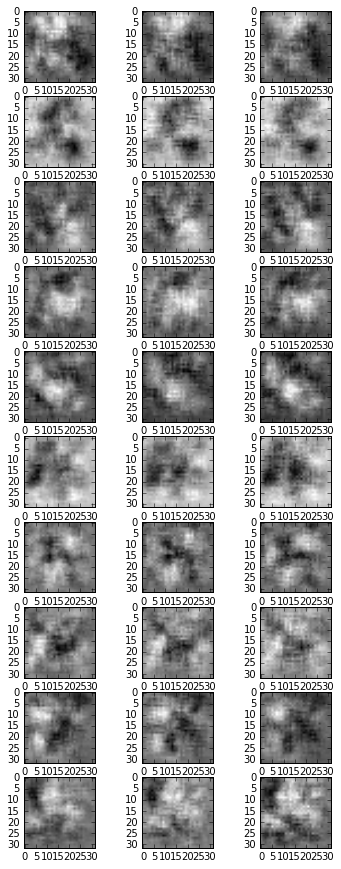

In [82]:
# visualize activation
record = record_activation(model)
plot_activation(record)

## Add Drouout layer to prevent overfitting

### Define model architecture

In [84]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten, Dropout

model = Sequential()
# Alternating convolutions and nonlinearities
model.add(Convolution2D(32, 3, 3, border_mode="same", input_shape=(3, 32, 32)))
model.add(Activation("relu"))
model.add(Convolution2D(32, 3, 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(32, 3, 3, border_mode="same"))
model.add(Activation("relu"))
model.add(Convolution2D(64, 3, 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# fully connected layers from here and connected to softmax layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

In [ ]:
model.fit(trainX, trainY, batch_size=128, nb_epoch=200, validation_split=0.1, verbose=0)

### Trained model for 200 epoch ...
- Not overfitting !!
<img src="with_dropout_loss_history.png" />

### Evaluate model

In [87]:
# Evaluate prediction accuracy
model.load_weights("cifar10_cnn_with_dropout_weight.h5")
evaluate_model(model, testX, testY)

             precision    recall  f1-score   support

          0       0.83      0.80      0.82      1000
          1       0.89      0.89      0.89      1000
          2       0.76      0.67      0.71      1000
          3       0.66      0.60      0.63      1000
          4       0.76      0.78      0.77      1000
          5       0.68      0.74      0.71      1000
          6       0.80      0.88      0.84      1000
          7       0.83      0.85      0.84      1000
          8       0.87      0.88      0.87      1000
          9       0.86      0.87      0.87      1000

avg / total       0.79      0.79      0.79     10000



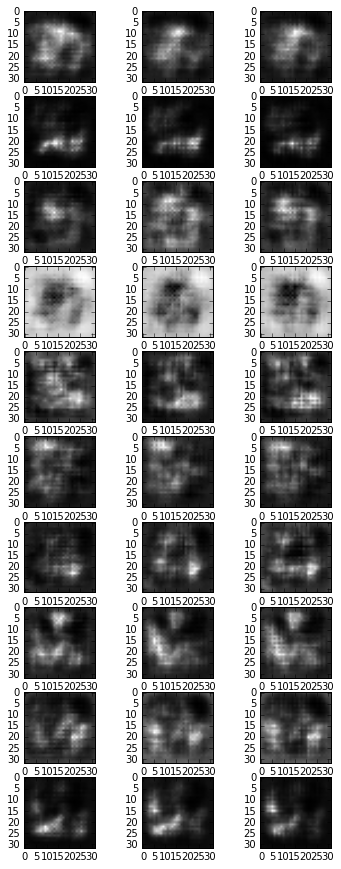

In [137]:
# record activation
cnv1, sftmx = model.layers[0], model.layers[-1]
inputs = [K.learning_phase()] + model.inputs
sftmx_output = K.function(inputs, [sftmx.output])
X = [np.zeros((32, 32)) for _ in range(3)]
X[0][0][0] = 1
sftmx_output([0] + [[X]])[0]

record = [[[None for k in range(32)] for j in range(32)] for i in range(3)]
for i in range(3):
    for j in range(32):
        for k in range(32):
            X = [np.zeros((32, 32)) for _ in range(3)]
            X[i][j][k] = 1
            record[i][j][k] = sftmx_output([0, [X]])[0]
            
# plot activation
plot_activation(record)